In [5]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [7]:
#req1 = req1[20000:2005000]
#gen_req1 = gen_req1[20000:2005000]
req1.shape,gen_req1.shape

((2005000,), (2255000,))

In [8]:
N = 100 # total ids 
pi = 3.14

LRU

In [9]:
def LRU(y, x, request_time,con):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  for j in range(J):
    x_t_j = np.zeros((N),int)
    file_req_time = np.zeros((N),int)

    # to find which users are connected to this cache 
    connected_users = np.where(con[:,j]==1)[0]
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    # file which is not requested but still in the cache
    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))
    a = np.where(a1 == 1)[0]
    # file requested but not in the cache.
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) 
    b = np.where(b1 == 1)[0]

    if len(a)>0 and len(b)>0:
      if len(a)>len(b):
        t = np.zeros(len(a))
        for k in range(len(a)):
          t[k] = file_req_time[a[k]]
        replace = (t).argsort()[:len(b)]
        for k in range(len(b)):
          y[j,a[int(replace[k])]] = 0
        for k in range(len(b)):
            y[j,b[k]] = 1
      
      else:
        t = np.zeros(len(b))
        for k in range(len(b)):
          t[k] = file_req_time[b[k]]
        replace = (t).argsort()[:len(a)]
        for k in range(len(a)):
          y[j,b[int(replace[k])]] = 1
        for k in range(len(a)):
          y[j,a[k]] = 0
  new = y.reshape(J*N)
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,download

LFU

In [10]:
def LFU(y,x,freq,con):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  for j in range(J):
    file_freq = np.zeros((N),int)
    x_t_j = np.zeros((N),int)

    # to find which users are connected to this cache 
    connected_users = np.where(con[:,j]==1)[0]
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    # file which is not requested but still in the cache
    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))
    a = np.where(a1 == 1)[0]
    # file requested but not in the cache.
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) 
    b = np.where(b1 == 1)[0]

    if len(a)>0 and len(b)>0:
      if len(a)>len(b):
        t = np.zeros(len(a))
        for k in range(len(a)):
          t[k] = file_freq[a[k]]
        replace = (t).argsort()[:len(b)]
        for k in range(len(b)):
          y[j,a[int(replace[k])]] = 0
        for k in range(len(b)):
            y[j,b[k]] = 1
      
      else:
        t = np.zeros(len(b))
        for k in range(len(b)):
          t[k] = file_freq[b[k]]
        replace = (t).argsort()[:len(a)]
        for k in range(len(a)):
          y[j,b[int(replace[k])]] = 1
        for k in range(len(a)):
          y[j,a[k]] = 0
  new = y.reshape(J*N)
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,download

perturbed count

In [11]:
def per_count(eta,count):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = 'f4')
  for i in range(I):
    p_count[:,i] = count[:,i] + np.round(np.multiply(eta, random.normal(0,1,[N,1])).reshape(N),4)
  return p_count

GREEDY

In [12]:
def Greedy(con,count):
  [I,J] = con.shape
  [N,I] = count.shape
  load = np.zeros((1,J),dtype = int)

  for i in range(I):
    for f in range(N):
      if count[f,i] < 0:
        count[f,i] = 0
  
  loadc = 0
  y = np.zeros((J,N),dtype = int)
  z = np.zeros((I,N),dtype = 'f4')
  mark = np.zeros((I,N),dtype = int)

  while(loadc < J):
    best_cache = -1
    best_file = -1
    best_imp = -1

    for j in range(J):
      if load[0,j] < C:
        for f in range(N):
          if y[j,f] != 1:
            imp = 0

            for i in range(I):
              if con[i,j] == 1 and mark[i,f] == 0:
                imp += count[f,i]

            if imp >= best_imp:
              best_cache = j
              best_file = f
              best_imp = imp

    y[best_cache,best_file] = 1

    for i in range(I):
      if con[i,best_cache] == 1:
        mark[i,best_file] = 1

    load[0,best_cache] += 1
    if load[0,best_cache] == C:
      loadc += 1
  
  for i in range(I):
    for f in range(N):
      for j in range(J):
        if con[i,j] == 1:
          z[i,f] = np.maximum(y[j,f],z[i,f])
      
  return y,z

MARKER

In [13]:
def Marker(y,x,bit,con,phase):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  
  for j in range(J):
    x_t_j = np.zeros((N),int)
    connected_users = np.where(con[:,j]==1)[0]
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
    x_t_j = np.minimum(np.ones((N),int),x_t_j)

    phase[j] += x_t_j   
    phase[j] = np.minimum(np.ones((N),int),phase[j]) 
    # new phase
    if np.sum(phase[j]) == C:
      bit[j,:] = np.zeros((1,N),int) #start new phase
      phase[j] = np.zeros((N),int)
      
    # file which is not requested but still in the cache
    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))
    a = np.where(a1 == 1)[0]
    # file requested but not in the cache.
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) 
    b = np.where(b1 == 1)[0]
    # file requested available in cache
    c1 = np.logical_and(y[j],x_t_j.reshape(1,N)).reshape(N)
    c = np.where(c1 == 1)[0]
    
    # if requested file is available then bit is set for that file
    for i in range(len(c)):
      bit[j,c[i]] = 1 
    
    # now replace add all b1 files in cache and evict randomly untill end of the face.
    for i in range(len(b)):
      for n in range(N):
        if np.logical_and(y[j,n],np.logical_not(bit[j,n])) == 1:
          y[j,n] = 0
          y[j,b[i]] = 1
          bit[j,n] = 1
          break
              
  new = y.reshape(J*N).copy()
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,bit,download,phase

SINGLE CACHE

In [14]:
I = 1 #users
T = 700000
degree = 1
J = 1 #caches
C = 5
connection = np.array([[1]])
connection.shape

(1, 1)

In [15]:
req = req1[:I*T].reshape(I,T)
req

array([[17, 80, 26, ...,  2, 63, 19]])

In [16]:
gen_req = gen_req1[:I*T].reshape(I,T)
gen_req

array([[17, 80, 26, ..., 46, 52, 73]])

In [17]:
y_LRU = np.zeros((J,N),dtype = int)
y_LFU = np.zeros((J,N),dtype = int)
y_FTPL = np.zeros((J,N),dtype = int)
y_LSTM = np.zeros((J,N),dtype = int)
y_mrk = np.zeros((J,N),dtype = int)
y_mrk[:,:C] = np.ones((J,C),dtype = int)
y_LSTM[:,:C] = np.ones((J,C),dtype = int)
y_FTPL[:,:C] = np.ones((J,C),dtype = int)
y_LRU[:,:C] = np.ones((J,C),dtype = int)
y_LFU[:,:C] = np.ones((J,C),dtype = int)
count = np.zeros((N,I),dtype = int)
reward_LSTM =  np.zeros((T),int)
reward_FTPL =  np.zeros((T),int)
reward_LRU =  np.zeros((T),int)
reward_LFU =  np.zeros((T),int)
reward_mrk =  np.zeros((T),int)
hits_mrk =  []
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
download_mrk = []
mrk_downloads_slotwise = np.zeros((T),int)
FTPL_downloads_slotwise = np.zeros((T),int)
LFU_downloads_slotwise = np.zeros((T),int)
LRU_downloads_slotwise = np.zeros((T),int)
LSTM_downloads_slotwise = np.zeros((T),int)
req_time = np.zeros((N,I),dtype = int) 
req_time1 = np.zeros((N,I),dtype = int) 
bit = np.zeros((J,N),int)
phase = np.zeros((J,N),int)

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros((I),int)
  ireward_LSTM =  np.zeros((I),int)
  ireward_LFU =  np.zeros((I),int)
  ireward_FTPL =  np.zeros((I),int)
  ireward_mrk =  np.zeros((I),int)
  
  for i in range(I):
    temp1 = np.zeros((N),int)
    temp2 = np.zeros((N),int)
    temp3 = np.zeros((N),int)
    temp4 = np.zeros((N),int)
    temp5 = np.zeros((N),int)

    connected_cache = np.where(connection[i] == 1)[0]
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
      temp5 += y_mrk[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])
    ireward_mrk[i] += np.dot(np.minimum(np.ones(N),temp5),x_t[:,i])


  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_mrk[t] =  np.sum(ireward_mrk)
  reward_mrkc = np.sum(reward_mrk)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  y_LFU, LFU_downloads_slotwise[t] = LFU(y_LFU,x_t,count,connection)
  y_LRU, LRU_downloads_slotwise[t] = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM, LSTM_downloads_slotwise[t] = LRU(y_LSTM,x_t1,req_time1,connection)
  y_mrk, bit, mrk_downloads_slotwise[t], phase = Marker(y_mrk,x_t,bit,connection,phase) 
  eta = round(I*pow(4*pi*np.log(N*I),-.25)*pow((t+1)/(J*degree*C),.5),4)
  perturbed_count=per_count(eta,count)
  old_FTPL = y_FTPL.reshape(J*N)
  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = int)
  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 
  new_FTPL = y_FTPL.reshape(J*N)
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
 
  download_mrk.append(np.sum(mrk_downloads_slotwise)/(t+1))
  download_FTPL.append(np.sum(FTPL_downloads_slotwise)/(t+1))
  download_LFU.append(np.sum(LFU_downloads_slotwise)/(t+1))
  download_LRU.append(np.sum(LRU_downloads_slotwise)/(t+1))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise)/(t+1))
  hits_mrk.append(reward_mrkc/(t+1))
  hits_LRU.append(reward_LRUc/(t+1))
  hits_LFU.append(reward_LFUc/(t+1))
  hits_FTPL.append(reward_FTPLc/(t+1))
  hits_LSTM.append(reward_LSTMc/(t+1))

  if t %10000 == 0:
    print(t,download_mrk[t],download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_mrk[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 1.0 3.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0
10000 0.9521047895210479 3.6833316668333165 0.9396060393960604 0.9476052394760524 0.9476052394760524 0.04789521047895211 0.056694330566943306 0.0603939606039396 0.052394760523947606 0.052394760523947606
20000 0.951502424878756 3.173041347932603 0.935703214839258 0.9496525173741313 0.9496525173741313 0.04849757512124394 0.06189690515474226 0.06429678516074196 0.05034748262586871 0.05034748262586871
30000 0.9508016399453352 2.8445051831605612 0.9342688577047432 0.9488017066097797 0.9205026499116696 0.049198360054664846 0.06353121562614579 0.06573114229525683 0.05119829339022033 0.07949735008833039
40000 0.9503512412189695 2.5636859078523035 0.9338516537086573 0.9479513012174695 0.9053273668158296 0.04964875878103048 0.06487337816554586 0.06614834629134271 0.052048698782530434 0.0946726331841704
50000 0.9494210115797684 2.3498930021399573 0.9347813043739125 0.9481210375792484 0.8962820743585128 0.0505789884202316 0.06483870322593548 0.065218695626

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


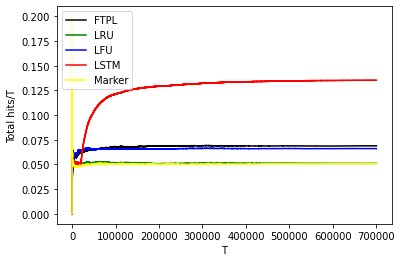

In [18]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.plot(hits_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('Total hits/T')
plt.legend()
plt.savefig('hit-rate(I=J=1).png')

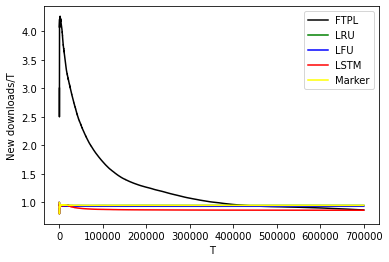

In [19]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.plot(download_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('New downloads/T')
plt.legend()
plt.savefig('download-rate(I=J=1).png')

I = 5 J = 3 d = 3

In [20]:
C = 5
I = 5
J = 3
degree = 3
T = 50000

In [21]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 1],
       [0, 1, 1],
       [0, 1, 0]])

In [22]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:]
gen_req1 = gen_req1[20000:]

In [23]:
req = req1.reshape(I,-1)
req.shape

(5, 397000)

In [24]:
gen_req = gen_req1.reshape(I,-1)
gen_req.shape

(5, 447000)

In [25]:
req

array([[76, 92, 49, ..., 63,  6, 83],
       [30, 32, 18, ..., 83, 79, 30],
       [67, 26, 42, ..., 68, 95, 61],
       [42,  4,  1, ..., 14, 64, 79],
       [55, 98, 27, ..., 16, 26, 14]])

In [26]:
gen_req

array([[64, 15, 95, ..., 15, 41, 77],
       [49,  8,  3, ..., 15, 41, 77],
       [33, 56, 51, ..., 15, 41, 77],
       [27, 78, 64, ..., 41, 15, 77],
       [64, 92, 46, ..., 15, 41, 77]])

In [27]:
y_LRU = np.zeros((J,N),dtype = int)
y_LFU = np.zeros((J,N),dtype = int)
y_FTPL = np.zeros((J,N),dtype = int)
y_LSTM = np.zeros((J,N),dtype = int)
y_mrk = np.zeros((J,N),dtype = int)
y_mrk[:,:C] = np.ones((J,C),dtype = int)
y_LSTM[:,:C] = np.ones((J,C),dtype = int)
y_FTPL[:,:C] = np.ones((J,C),dtype = int)
y_LRU[:,:C] = np.ones((J,C),dtype = int)
y_LFU[:,:C] = np.ones((J,C),dtype = int)
count = np.zeros((N,I),dtype = int)
reward_LSTM =  np.zeros((T),int)
reward_FTPL =  np.zeros((T),int)
reward_LRU =  np.zeros((T),int)
reward_LFU =  np.zeros((T),int)
reward_mrk =  np.zeros((T),int)
hits_mrk =  []
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
download_mrk = []
mrk_downloads_slotwise = np.zeros((T),int)
FTPL_downloads_slotwise = np.zeros((T),int)
LFU_downloads_slotwise = np.zeros((T),int)
LRU_downloads_slotwise = np.zeros((T),int)
LSTM_downloads_slotwise = np.zeros((T),int)
req_time = np.zeros((N,I),dtype = int) 
req_time1 = np.zeros((N,I),dtype = int) 
bit = np.zeros((J,N),int)
phase = np.zeros((J,N),int)
for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros((I),int)
  ireward_LSTM =  np.zeros((I),int)
  ireward_LFU =  np.zeros((I),int)
  ireward_FTPL =  np.zeros((I),int)
  ireward_mrk =  np.zeros((I),int)
  
  for i in range(I):
    temp1 = np.zeros((N),int)
    temp2 = np.zeros((N),int)
    temp3 = np.zeros((N),int)
    temp4 = np.zeros((N),int)
    temp5 = np.zeros((N),int)

    connected_cache = np.where(connection[i] == 1)[0]
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
      temp5 += y_mrk[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])
    ireward_mrk[i] += np.dot(np.minimum(np.ones(N),temp5),x_t[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_mrk[t] =  np.sum(ireward_mrk)
  reward_mrkc = np.sum(reward_mrk)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection)
  [y_mrk,bit,mrk_downloads_slotwise[t],phase] = Marker(y_mrk,x_t,bit,connection,phase) 

  eta = round(I*pow(4*pi*np.log(N*I),-.25)*pow((t+1)/(J*degree*C),.5),4)
  perturbed_count=per_count(eta,count)
  old_FTPL = y_FTPL.reshape(J*N).copy()
  [y_FTPL,Z] = Greedy(connection,perturbed_count) 
  new_FTPL = y_FTPL.reshape(J*N).copy()
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))

  download_mrk.append(np.sum(mrk_downloads_slotwise)/(t+1))
  download_FTPL.append(np.sum(FTPL_downloads_slotwise)/(t+1))
  download_LFU.append(np.sum(LFU_downloads_slotwise)/(t+1))
  download_LRU.append(np.sum(LRU_downloads_slotwise)/(t+1))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise)/(t+1))
  hits_mrk.append(reward_mrkc/(t+1))
  hits_LRU.append(reward_LRUc/(t+1))
  hits_LFU.append(reward_LFUc/(t+1))
  hits_FTPL.append(reward_FTPLc/(t+1))
  hits_LSTM.append(reward_LSTMc/(t+1))

  if t %10000 == 0:
    print(t,download_mrk[t],download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_mrk[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 9.0 15.0 9.0 9.0 8.0 0.0 0.0 0.0 0.0 0.0
10000 0.004299570042995701 12.624137586241376 8.375662433756624 8.440455954404559 7.727627237276272 0.39416058394160586 0.5253474652534746 0.39906009399060094 0.3648635136486351 0.7036296370362963
20000 0.0021498925053747312 12.106094695265236 8.379681015949203 8.450677466126693 7.71996400179991 0.39718014099295035 0.5366731663416829 0.38908054597270136 0.35948202589870504 0.703964801759912
30000 0.001433285557148095 11.772874237525416 8.381653944868505 8.449651678277391 7.702276590780308 0.39892003599880005 0.5400486650444986 0.38025399153361555 0.3612212926235792 0.7129762341255291
40000 0.0010749731256718582 11.576110597235068 8.379965500862479 8.451438714032149 7.703107422314442 0.399240018999525 0.5459113522161946 0.3755656108597285 0.36034099147521315 0.7131321716957076


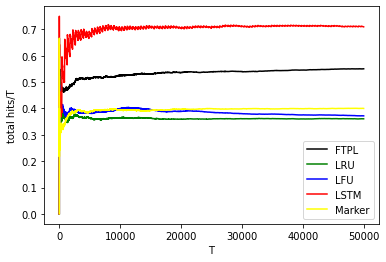

In [28]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.plot(hits_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('total hits/T')
plt.legend()
plt.savefig('hit-rate(I=5 J=3 d=3).png')

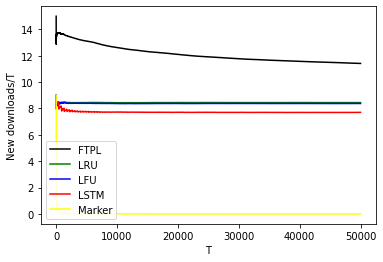

In [29]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.plot(download_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('New downloads/T')
plt.legend()
plt.savefig('download-rate(I=5 J=3 d=3).png')

I = 15 J = 10 d = 7

In [41]:
I = 10
J = 4
C = 10
degree = 3
T = 50000

In [42]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [43]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:]
gen_req1 = gen_req1[20000:]

In [44]:
req = req1.reshape(I,-1)
req.shape

(10, 198500)

In [45]:
gen_req = gen_req1.reshape(I,-1)
gen_req.shape

(10, 223500)

In [46]:
y_LRU = np.zeros((J,N),dtype = int)
y_LFU = np.zeros((J,N),dtype = int)
y_FTPL = np.zeros((J,N),dtype = int)
y_LSTM = np.zeros((J,N),dtype = int)
y_mrk = np.zeros((J,N),dtype = int)
y_mrk[:,:C] = np.ones((J,C),dtype = int)
y_LSTM[:,:C] = np.ones((J,C),dtype = int)
y_FTPL[:,:C] = np.ones((J,C),dtype = int)
y_LRU[:,:C] = np.ones((J,C),dtype = int)
y_LFU[:,:C] = np.ones((J,C),dtype = int)
count = np.zeros((N,I),dtype = int)
reward_LSTM =  np.zeros((T),int)
reward_FTPL =  np.zeros((T),int)
reward_LRU =  np.zeros((T),int)
reward_LFU =  np.zeros((T),int)
reward_mrk =  np.zeros((T),int)
hits_mrk =  []
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
download_mrk = []
mrk_downloads_slotwise = np.zeros((T),int)
FTPL_downloads_slotwise = np.zeros((T),int)
LFU_downloads_slotwise = np.zeros((T),int)
LRU_downloads_slotwise = np.zeros((T),int)
LSTM_downloads_slotwise = np.zeros((T),int)
req_time = np.zeros((N,I),dtype = int) 
req_time1 = np.zeros((N,I),dtype = int) 
bit = np.zeros((J,N),int)
phase = np.zeros((J,N),int)
for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros((I),int)
  ireward_LSTM =  np.zeros((I),int)
  ireward_LFU =  np.zeros((I),int)
  ireward_FTPL =  np.zeros((I),int)
  ireward_mrk =  np.zeros((I),int)
  
  for i in range(I):
    temp1 = np.zeros((N),int)
    temp2 = np.zeros((N),int)
    temp3 = np.zeros((N),int)
    temp4 = np.zeros((N),int)
    temp5 = np.zeros((N),int)

    connected_cache = np.where(connection[i] == 1)[0]
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
      temp5 += y_mrk[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])
    ireward_mrk[i] += np.dot(np.minimum(np.ones(N),temp5),x_t[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_mrk[t] =  np.sum(ireward_mrk)
  reward_mrkc = np.sum(reward_mrk)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection)
  [y_mrk,bit,mrk_downloads_slotwise[t],phase] = Marker(y_mrk,x_t,bit,connection,phase) 

  eta = round(I*pow(4*pi*np.log(N*I),-.25)*pow((t+1)/(J*degree*C),.5),4)
  perturbed_count=per_count(eta,count)
  old_FTPL = y_FTPL.reshape(J*N).copy()
  [y_FTPL,Z] = Greedy(connection,perturbed_count) 
  new_FTPL = y_FTPL.reshape(J*N).copy()
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))

  download_mrk.append(np.sum(mrk_downloads_slotwise)/(t+1))
  download_FTPL.append(np.sum(FTPL_downloads_slotwise)/(t+1))
  download_LFU.append(np.sum(LFU_downloads_slotwise)/(t+1))
  download_LRU.append(np.sum(LRU_downloads_slotwise)/(t+1))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise)/(t+1))
  hits_mrk.append(reward_mrkc/(t+1))
  hits_LRU.append(reward_LRUc/(t+1))
  hits_LFU.append(reward_LFUc/(t+1))
  hits_FTPL.append(reward_FTPLc/(t+1))
  hits_LSTM.append(reward_LSTMc/(t+1))

  if t %1000 == 0:
    print(t,download_mrk[t],download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_mrk[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 12.0 37.0 12.0 12.0 12.0 0.0 0.0 0.0 0.0 0.0
1000 0.10589410589410589 34.08191808191808 10.552447552447552 10.708291708291709 9.764235764235764 1.2157842157842158 1.2877122877122877 1.2277722277722278 1.066933066933067 1.864135864135864
2000 0.05297351324337831 33.44777611194403 10.498750624687656 10.668665667166417 9.734132933533234 1.2188905547226387 1.3098450774612693 1.2648675662168916 1.091454272863568 1.8610694652673663
3000 0.03532155948017328 33.045651449516825 10.509496834388537 10.677440853048983 9.712762412529157 1.1952682439186937 1.3138953682105965 1.2529156947684106 1.0813062312562478 1.869710096634455
4000 0.02649337665583604 32.68557860534866 10.514121469632592 10.689077730567359 9.628342914271432 1.1834541364658835 1.321669582604349 1.2434391402149463 1.068732816795801 1.9275181204698826
5000 0.021195760847830435 32.34573085382923 10.495300939812038 10.683063387322536 9.593081383723256 1.1819636072785442 1.3339332133573285 1.255348930213957 1.0745850829834034 1.95280

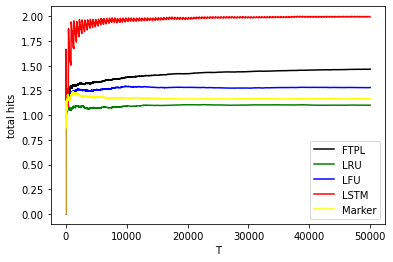

In [49]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.plot(hits_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('hit-rate(I=10 J=4 d=3).png')

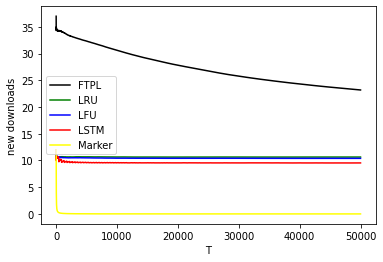

In [50]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.plot(download_mrk,'yellow',label='Marker')
plt.xlabel('T')
plt.ylabel('new downloads')
plt.legend()
plt.savefig('download-rate(I=10 J=4 d=3).png')